# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss_history_ = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        sigm = []
        for i in range(X.shape[0]):
            sigm.append(1 / (1 + math.exp(-1 * (weights * X[i]).sum())))
        return sigm
    
    def get_loss(self, X, weights, y):
        """Calculate the loss."""
        sum_ = 0
        for i in range(X.shape[0]):
            sum_ += np.log(1 + math.exp(-y[i] * (weights * X[i]).sum()))
        reg =  (weights ** 2).sum()/(2 * self.C)
        return sum_ / X.shape[0] + reg
    
    
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        for it in range(self.max_iter):
            sum_ = 0
            for i in range(X.shape[0]):
                sum_ += y[i] * X_ext[i] * (1 - 1 / (1 + math.exp(-1 * y[i] * (self.weights_ * X_ext[i]).sum())))
                
            delta = (1 / X.shape[0]) * sum_ - (1 / self.C) * self.weights_
            self.weights_ += self.eta * delta
            
            self.loss_history_.append([it, self.get_loss(X_ext, self.weights_, y)])
            
            if ((self.eta * delta) ** 2).sum() ** 0.5 < self.tol:
                return it, ((self.eta * delta) ** 2).sum() ** 0.5

                
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return np.array(self.get_sigmoid(X_ext, self.weights_))
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        pr_proba = self.predict_proba(X)
        return np.where(pr_proba >= 0.5, 1, -1)
        


In [5]:
from sklearn import datasets
from sklearn import metrics

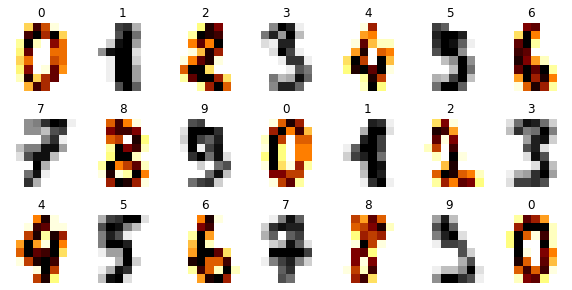

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test, show_plot=True):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [11]:
lr_clf.fit(X_train, y_train)

In [12]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [13]:
model = CustomLogisticRegression()

C:\Users\kasia\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


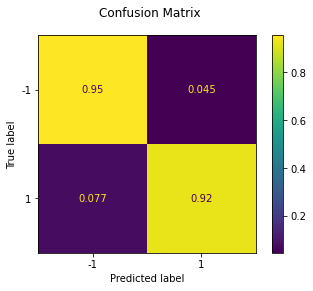

In [14]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [15]:
print(train_acc, test_acc)

0.9109255393180237 0.9388888888888889


In [16]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

<AxesSubplot:xlabel='iteration'>

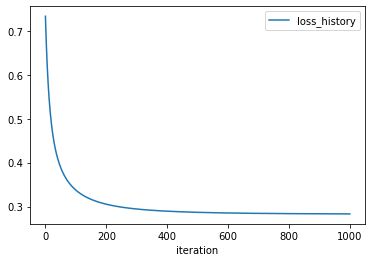

In [17]:
loss_hist = pd.DataFrame(model.loss_history_, columns=["iteration", "loss_history"]).set_index("iteration")
loss_hist.plot()

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

<AxesSubplot:xlabel='eta'>

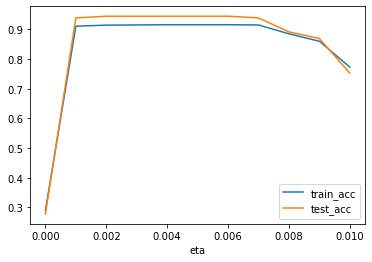

In [18]:
acc = []
for eta in np.linspace(0, 0.01, 1 + 10):
    model = CustomLogisticRegression(eta=eta)
    model.fit(X_train, y_train)
    train_acc = metrics.accuracy_score(y_pred=model.predict(X_train), y_true=y_train)
    test_acc = metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
    acc.append([eta, train_acc, test_acc])
    
acc_data = pd.DataFrame(acc, columns=["eta", "train_acc", "test_acc"]).set_index("eta")
acc_data.plot()

In [19]:
acc_data.query("test_acc == test_acc.max()")

,train_acc,test_acc
eta,,
0.002,0.914405,0.944444
0.003,0.915101,0.944444
0.004,0.915797,0.944444
0.005,0.915797,0.944444
0.006,0.915797,0.944444


The best test accuracy can be reached for learning rates in range **0.002-0.006**, the best train and test accuracy together in range **0.004-0.006**

**(0.5 points)** Try different regularization parameter values and compare the model quality.

<AxesSubplot:xlabel='C'>

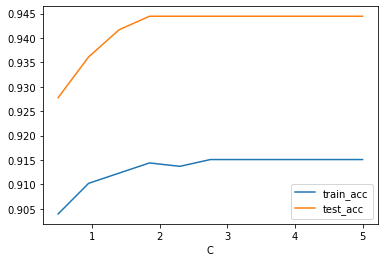

In [20]:
acc = []
for C in np.linspace(0.5, 5, 1 + 10):
    model = CustomLogisticRegression(C=C)
    model.fit(X_train, y_train)
    train_acc = metrics.accuracy_score(y_pred=model.predict(X_train), y_true=y_train)
    test_acc = metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
    acc.append([C, train_acc, test_acc])
    
acc_data = pd.DataFrame(acc, columns=["C", "train_acc", "test_acc"]).set_index("C")
acc_data.plot()

In [21]:
acc_data.query("test_acc == test_acc.max()")

,train_acc,test_acc
C,,
1.85,0.914405,0.944444
2.30,0.913709,0.944444
2.75,0.915101,0.944444
3.20,0.915101,0.944444
3.65,0.915101,0.944444
4.10,0.915101,0.944444
4.55,0.915101,0.944444
5.00,0.915101,0.944444


The minimum regularization parameter value thar gives the best train and test accuracy is **2.75**

**(0.5 points)** Compare zero initialization and random initialization. 

C:\Users\kasia\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


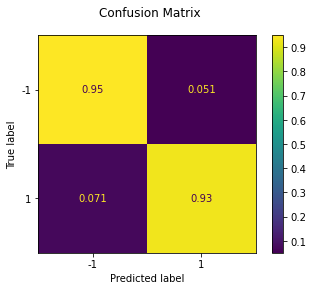

C:\Users\kasia\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


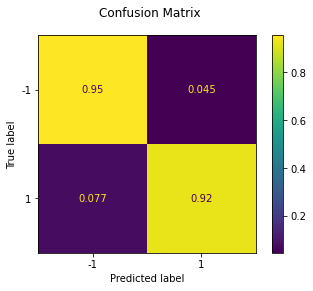

In [22]:
model = CustomLogisticRegression(zero_init=True)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

model = CustomLogisticRegression(zero_init=False)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

Zero initialization gives a litle bit better results comparing to random initialization - true positive accuracy is 0.93 to 0.92 for random initialization.

C:\Users\kasia\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


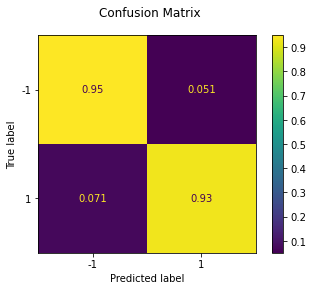

0.918580375782881 0.9388888888888889


In [23]:
model = CustomLogisticRegression(eta=0.004, C=2.75, zero_init=True)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print(train_acc, test_acc)

The best accuracy for tuned learning rate, regularization parameter and for zero initizlized coefficients it 0.919 for train and 0.939 for test comparing to 0.911 and 0.936 respectively  for default values of this parameters.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [11]:
import numpy as np
X = np.array([[1, 2, 3], [2, 3, 5]])
Y = np.array([[1, 2, 3], [2, 3, 4]])
print(X[:, None, :].shape)
print(Y[None, :, :].shape)
print(X[:, None, :] - Y[None, :, :])
np.linalg.norm(X[:, None, :] - Y[None, :, :], axis=-1)

(2, 1, 3)
(1, 2, 3)
[[[ 0  0  0]
  [-1 -1 -1]]

 [[ 1  1  2]
  [ 0  0  1]]]


array([[0.        , 1.73205081],
       [2.44948974, 1.        ]])

In [24]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        return np.linalg.norm(X[:, None, :] - Y[None, :, :], axis=-1)
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        if hasattr(self, 'classes_'):
            y_w = pd.DataFrame({"class": np.ravel(y), "weight": np.ravel(weights)})
            cl_w = y_w.groupby("class").weight.sum()
            cl = pd.DataFrame({"class": self.classes_}).set_index("class")
            return cl.join(cl_w).fillna(0).weight
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            #get n nearest neighbors indeces
            neig_inx = np.argsort(P)[:, :self.n_neighbors]
            neigh_dist = np.sort(P)[:, :self.n_neighbors]
            #get classes for these neighbors
            neig_cl = self.y[neig_inx]
            
            weights_of_points = np.ones(neigh_dist.shape)
            if self.weights == 'distance':
                weights_of_points = 1/(neigh_dist + self.eps)
            probas = []
            for i in range(X.shape[0]):
                cl_w = self.get_class_weights(neig_cl[i], weights_of_points[i])
                p_i = np.around(cl_w/cl_w.sum(), 8)
                probas.append(p_i)
                
            return np.array(probas)
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]


In [25]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [26]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [27]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

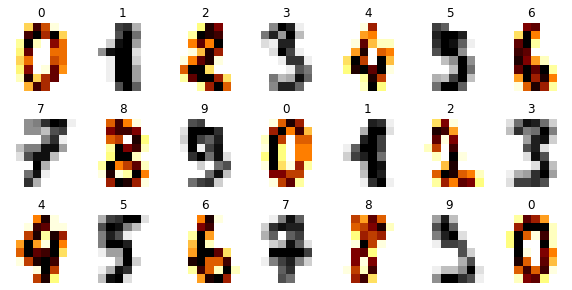

In [28]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [29]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [30]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

C:\Users\kasia\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


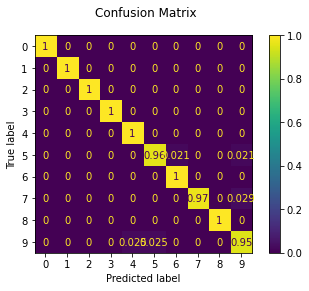

In [31]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [32]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

Model confuses numbers 5 (with 6 and 9), 7 (with 9), 9 (with 4 and 5). It hapens due to similar pixels used sometimes for this numbers.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [33]:
import warnings
warnings.filterwarnings('ignore')

K = 1


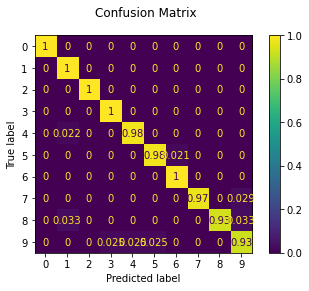

K = 3


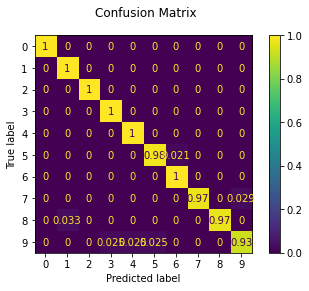

K = 5


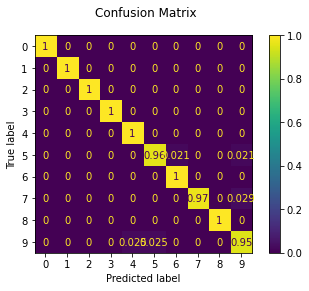

K = 7


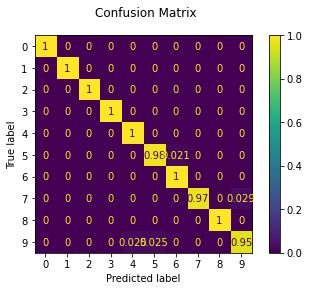

K = 8


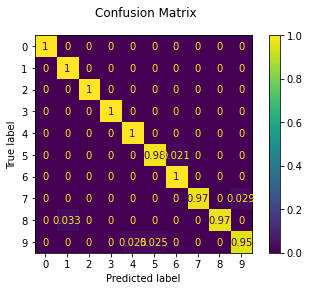

K = 9


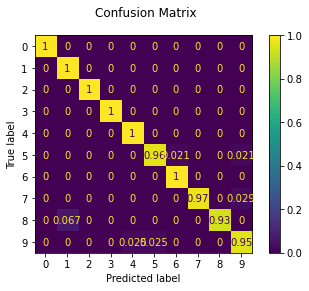

K = 10


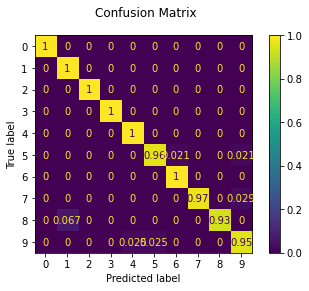

K = 15


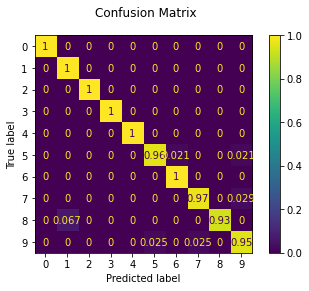

K = 20


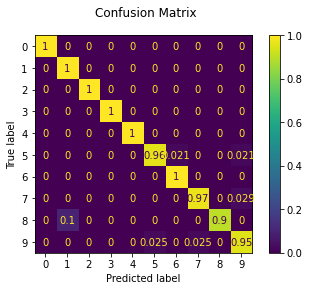

In [34]:
train_accs = []
test_accs = []
k_arr = [1, 3, 5, 7, 8, 9, 10, 15, 20]
for k in k_arr:
    model = CustomKNeighborsClassifier(n_neighbors=k, weights='distance')
    print(f"K = {k}")
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

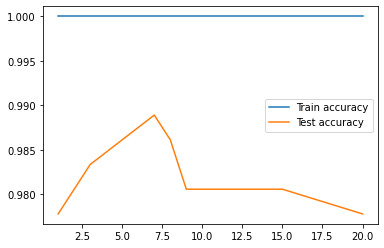

In [35]:
plt.plot(k_arr, train_accs, label="Train accuracy")
plt.plot(k_arr, test_accs, label="Test accuracy")
plt.legend()
plt.show()

For neighbors count K = 7 we get the best probabilities and accuracy. For higher K overfitting starts.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

Uniform


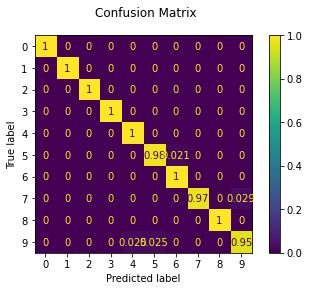

test_acc =  0.9888888888888889
Distance


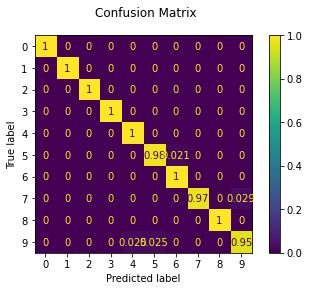

test_acc =  0.9888888888888889


In [36]:
print("Uniform")
model = CustomKNeighborsClassifier(n_neighbors=7)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print('test_acc = ', test_acc)
print("Distance")
model = CustomKNeighborsClassifier(n_neighbors=7, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print('test_acc = ', test_acc)

I our case both type of weights give the same result. I suppose weighted KNN is better to use when we have imbalanced data (there is a big difference in classes sizes) - than adding distance importance will compensate the smaller count of neighbors.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

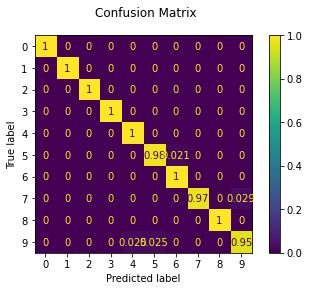

Metric: euclidean, test accuracy: 0.9888888888888889


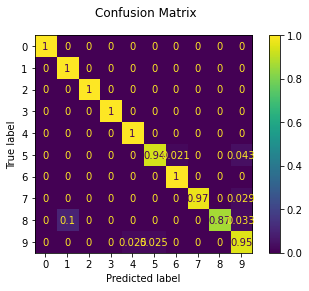

Metric: manhattan, test accuracy: 0.9722222222222222


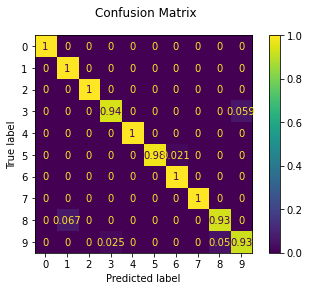

Metric: chebyshev, test accuracy: 0.9777777777777777


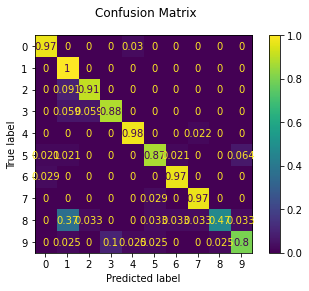

Metric: hamming, test accuracy: 0.8861111111111111


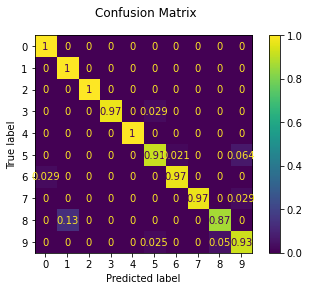

Metric: canberra, test accuracy: 0.9611111111111111


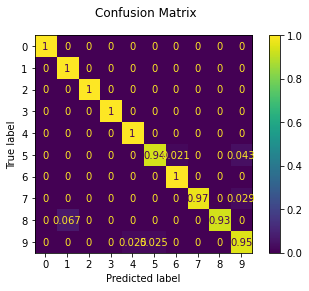

Metric: braycurtis, test accuracy: 0.9777777777777777


In [37]:
for m in ["euclidean", "manhattan", "chebyshev", "hamming", "canberra", "braycurtis"]:
    knn = KNeighborsClassifier(n_neighbors=7, weights='distance', metric=m)
    train_acc, test_acc = fit_evaluate(knn, X_train, y_train, X_test, y_test)
    print(f"Metric: {m}, test accuracy: {test_acc}")

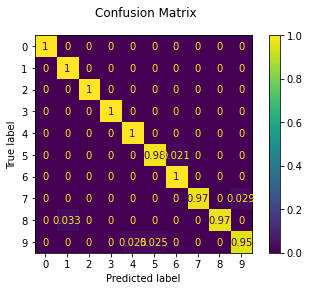

Metric: minkowski, p = 3, test accuracy: 0.9861111111111112


In [38]:
m = "minkowski"
p = 3
knn = KNeighborsClassifier(n_neighbors=7, weights='distance', metric=m, p=p)
train_acc, test_acc = fit_evaluate(knn, X_train, y_train, X_test, y_test)
print(f"Metric: {m}, p = {p}, test accuracy: {test_acc}")

I haven't found better than euclidean metric. Probably we can improve model using custom distance metric where we calcucalte distance between one pixel in x_i and this pixel and its' neighbors in x_j - because digit could be written with a shift or a slope.

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [39]:
PATH = "./datasets/"

In [40]:
pass_data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [41]:
pass_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [42]:
pass_data.columns = list(map(str.lower, pass_data.columns.to_list()))

pass_data.loc[:, "survived_cat"] = pass_data.survived.map({0: "Deceased", 1: "Survived"})
pass_data.survived_cat = pd.Categorical(pass_data.survived_cat, categories=["Survived", "Deceased"], ordered=True)
pass_data.pclass = pass_data.pclass.astype('category')

### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [43]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')
sns.set_palette('Set2')
matplotlib.rcParams['font.size'] = 12

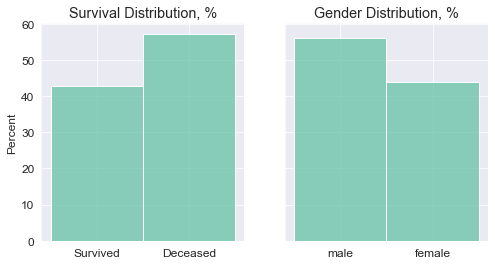

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(8,4), sharey=True)
sns.histplot(data=pass_data, x="survived_cat", stat="percent", ax=ax[0])
ax[0].set(xlabel='')
ax[0].title.set_text("Survival Distribution, %")

sns.histplot(data=pass_data, x="sex", stat="percent", ax=ax[1])
ax[1].set(xlabel='')
ax[1].title.set_text("Gender Distribution, %")

Text(0.5, 1.0, 'Surviving among Men and Women')

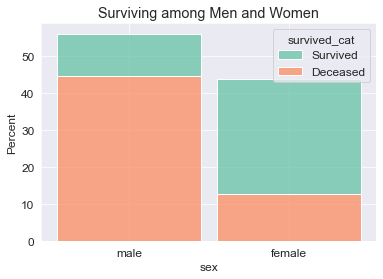

In [45]:
sns.histplot(data=pass_data, x="sex", hue="survived_cat", stat="percent", multiple="stack", shrink=.9)
plt.title("Surviving among Men and Women")

In [46]:
surv_men = pass_data[(pass_data["sex"] == "male") & pass_data["survived"]].shape[0]
surv_men_coef = surv_men/pass_data[pass_data["sex"] == "male"].shape[0]
print("{:.0%} of men survived.".format(surv_men_coef))
surv_women = pass_data[(pass_data["sex"] == "female") & pass_data["survived"]].shape[0]
surv_women_coef = surv_women/pass_data[pass_data["sex"] == "female"].shape[0]
print("{:.0%} of women survived.".format(surv_women_coef))

21% of men survived.
71% of women survived.


It's known that Titanics captain order was to take on lifeboats only women and children. We can see that in our dataset correlation between survival and sex is very strong and 80% men deceased however 71$ women survived. The order wasn't far from being executed. Let's check what about children and age dependence at all.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

Text(0.5, 1.0, 'Passengers Ages Distribution')

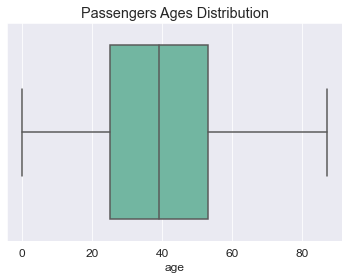

In [47]:
sns.boxplot(data=pass_data, x="age")
plt.title("Passengers Ages Distribution")

Text(0.5, 1.0, 'Passengers Ages Distribution')

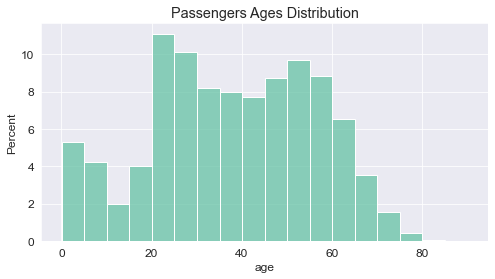

In [48]:
plt.figure(figsize=(8, 4))
sns.histplot(data=pass_data, x="age", binwidth=5, stat="percent")
plt.title("Passengers Ages Distribution")

In [49]:
print("Age mean:", pass_data["age"].mean())
print("Age median:", pass_data["age"].median())

Age mean: 38.35547214294576
Age median: 39.0


Text(0.5, 1.0, 'Survivng by ages distribution')

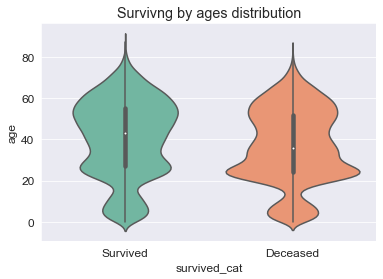

In [50]:
sns.violinplot(x="survived_cat", y="age", data=pass_data)
plt.title("Survivng by ages distribution")

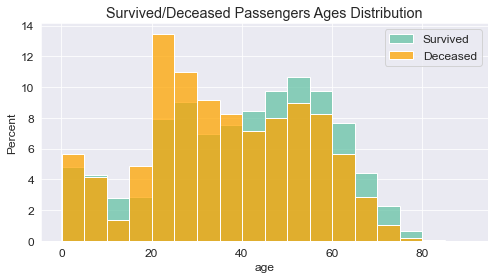

In [51]:
plt.figure(figsize=(8, 4))
sns.histplot(data=pass_data.query("survived==1"), x="age", binwidth=5, stat="percent", label="Survived")
sns.histplot(data=pass_data.query("survived==0"), x="age", binwidth=5, stat="percent", label="Deceased", color="orange")
plt.title("Survived/Deceased Passengers Ages Distribution")
plt.legend()

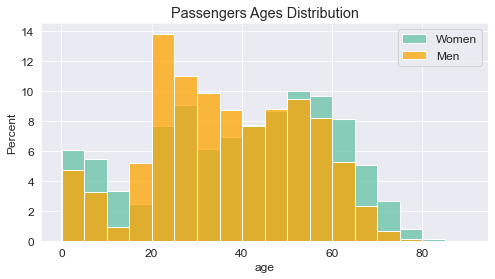

In [52]:
plt.figure(figsize=(8, 4))
sns.histplot(data=pass_data.query("sex=='female'"), x="age", binwidth=5, stat="percent", label="Women")
sns.histplot(data=pass_data.query("sex=='male'"), x="age", binwidth=5, stat="percent", label="Men", color="orange")
plt.title("Passengers Ages Distribution")
plt.legend()

Age distributions differ for survived and deceased passengers similar as for men and women especially in range 15-40 years. We can infer that age isn't important feature for survival prediction in this case.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

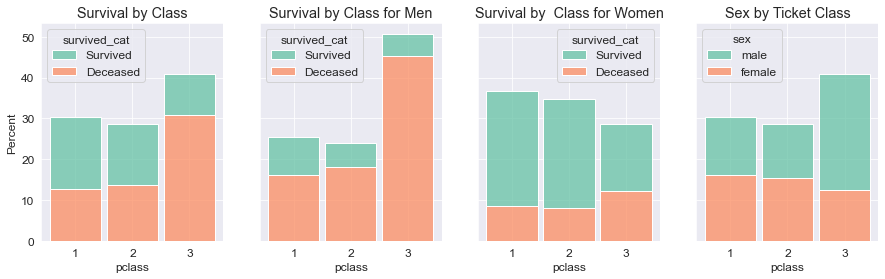

In [53]:
fig, ax = plt.subplots(1, 4, figsize=(15,4), sharey=True)

sns.histplot(data=pass_data, x="pclass", hue="survived_cat", stat="percent", multiple="stack", shrink=.9, ax=ax[0])
ax[0].title.set_text("Survival by Class")

sns.histplot(data=pass_data[pass_data.sex == "male"], x="pclass", hue="survived_cat", stat="percent", 
             multiple="stack", shrink=.9, ax=ax[1])
ax[1].title.set_text("Survival by Class for Men")

sns.histplot(data=pass_data[pass_data.sex == "female"], x="pclass", hue="survived_cat", stat="percent", 
             multiple="stack", shrink=.9, ax=ax[2])
ax[2].title.set_text("Survival by  Class for Women")

sns.histplot(data=pass_data, x="pclass", hue="sex", stat="percent", 
             multiple="stack", shrink=.9, ax=ax[3])
ax[3].title.set_text("Sex by Ticket Class")

There's a strong survival correlation with ticket class: while more than half of passengers of 1st and 2nd class survived, 3/4 of passengers of 3rd class deceased. Percents of deceased men in 3rd class is 10% more than in 2nd and 24% more than in 1st class. The number of deceased men in 3rd class was almost the same as in 1st and 2nd together. Women are spreaded by classes more evenly: about 29% in 3rd class, 34% in 2nd class, 37% in 1st class. About 24% of women if 1st and 2nd classes deceased and 41% in 3rd class. So sex and ticket class both are strong correlated with survival.

The most safe was the 1st class.

Text(0.5, 1.0, 'Survival by Embarkation Port')

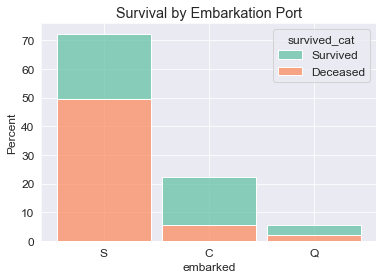

In [54]:
sns.histplot(data=pass_data, x="embarked", hue="survived_cat", stat="percent", multiple="stack", shrink=.9)
plt.title("Survival by Embarkation Port")

Text(0.5, 1.0, 'Survival by Embarkation Port')

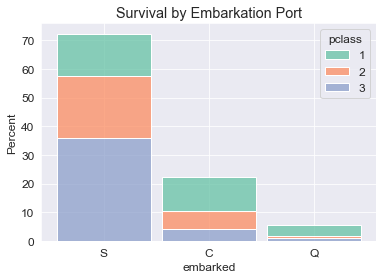

In [55]:
sns.histplot(data=pass_data, x="embarked", hue="pclass", stat="percent", multiple="stack", shrink=.9)
plt.title("Survival by Embarkation Port")

Survival is low for Southampton because mostly passengers on 3rd ticket class were boaded there and little of 1st class passengers. So there is no straight correlation between port and survival.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [56]:
percent_missing = round(pass_data.isnull().sum() * 100 / len(pass_data), 2)
missing_value_df = pd.DataFrame({'column_name': pass_data.columns,
                                 'percent_missing, %': percent_missing})
missing_value_df

,column_name,"percent_missing, %"
survived,survived,0.00
pclass,pclass,0.00
name,name,0.00
sex,sex,0.00
age,age,3.29
sibsp,sibsp,0.00
parch,parch,0.00
ticket,ticket,4.62
fare,fare,0.13
cabin,cabin,67.87


In [57]:
pass_data.cabin.unique().size

26993

In [58]:
pass_data.ticket.unique().size

75332

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

**Cabin** has 67.87% of missing values and 26993 unique values - it isn't categorical, we can't use it for modeling - will drop this column. 

**Ticket** has 4.62% of missing values and 75331 unique values - it isn't categorical, we can't use it for modeling - will drop this column.

**Age** has 3.29% of missing values and we can fill them with the mean. Dropping rows with missing values will cause data looses.

**Embarked** is a categorical data and has only 0.25% of missing data, so it's better to fill its missing data with mode.

**Fare** has only 0.13% of missing values and we can fill them with the mean. 


**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [59]:
pass_data.age.fillna(pass_data.age.mean(), inplace=True)
pass_data.embarked.fillna(pass_data.embarked.mode()[0], inplace=True)
pass_data.fare.fillna(pass_data.fare.mean(), inplace=True)
pass_data.isnull().sum()

survived            0
pclass              0
name                0
sex                 0
age                 0
sibsp               0
parch               0
ticket           4623
fare                0
cabin           67866
embarked            0
survived_cat        0
dtype: int64

At first let's try to use all features except of **name**, **cabin** and **ticket**. We have to change **sex** and **embarked** types to numeric to use them in modeling.

In [60]:
pass_data.embarked.unique()

array(['S', 'C', 'Q'], dtype=object)

In [61]:
X = pass_data.drop(columns=["survived", "survived_cat", "name", "cabin", "ticket"]).copy()
X.sex = X.sex.map({"male": 0, "female" : 1})
X.embarked = X.embarked.map({"S": 0, "C" : 1, "Q" : 2})
X

,pclass,sex,age,sibsp,parch,fare,embarked
PassengerId,,,,,,,
0,1,0,38.355472,2,0,27.14,0
1,3,0,38.355472,0,0,13.35,0
2,3,0,0.330000,1,2,71.29,0
3,3,0,19.000000,0,0,13.04,0
4,3,0,25.000000,0,0,7.76,0
...,...,...,...,...,...,...,...
99995,2,1,62.000000,0,0,14.86,1
99996,2,0,66.000000,0,0,11.15,0
99997,3,0,37.000000,0,0,9.95,0


In [62]:
y = pass_data.survived.copy()
y

PassengerId
0        1
1        0
2        0
3        0
4        1
        ..
99995    1
99996    0
99997    0
99998    0
99999    0
Name: survived, Length: 100000, dtype: int64

In [63]:
results = cross_validate(LogisticRegression(random_state=42, max_iter=1000), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='accuracy')

In [64]:
print('train score mean:', results['train_score'].mean())
print('test score mean:', results['test_score'].mean())

train score mean: 0.7582650000000001
test score mean: 0.75819


In [65]:
results = cross_validate(KNeighborsClassifier(), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='accuracy')

In [66]:
print('train score mean:', results['train_score'].mean())
print('test score mean:', results['test_score'].mean())

train score mean: 0.8058449999999999
test score mean: 0.7219999999999999


For models with default parameters test accuracy is better for Logistic Regression model.

In [67]:
X = X.drop(columns=["age"])

In [68]:
results = cross_validate(LogisticRegression(random_state=42, max_iter=1000), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='accuracy')
print('train score mean:', results['train_score'].mean())
print('test score mean:', results['test_score'].mean())

train score mean: 0.7582925
test score mean: 0.75827


In [69]:
results = cross_validate(KNeighborsClassifier(), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='accuracy')
print('train score mean:', results['train_score'].mean())
print('test score mean:', results['test_score'].mean())

train score mean: 0.8116275
test score mean: 0.73812


Accuracy is better without **age** feature.

In [70]:
X = X.drop(columns=["embarked"])

In [71]:
results = cross_validate(LogisticRegression(random_state=42, max_iter=1000), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='accuracy')
print('train score mean:', results['train_score'].mean())
print('test score mean:', results['test_score'].mean())

train score mean: 0.7577825
test score mean: 0.7577699999999999


In [72]:
results = cross_validate(KNeighborsClassifier(), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='accuracy')
print('train score mean:', results['train_score'].mean())
print('test score mean:', results['test_score'].mean())

train score mean: 0.8025399999999999
test score mean: 0.72852


Accurate decreases without **embarked** feature. Let's leave it.

In [73]:
X = pass_data.drop(columns=["survived", "survived_cat", "name", "cabin", "ticket", "age"]).copy()
X.sex = X.sex.map({"male": 0, "female" : 1})
X.embarked = X.embarked.map({"S": 0, "C" : 1, "Q" : 2})

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [74]:
from sklearn.model_selection import GridSearchCV

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [76]:
lr_param_grid = {'C': [0.01, 0.1, 1.0],
                 'class_weight': [None, 'balanced'],
                }
lr_clf = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000, solver='saga'), lr_param_grid)
lr_clf.fit(X_train, y_train)
mean, std = lr_clf.cv_results_['mean_test_score'][lr_clf.best_index_], \
                lr_clf.cv_results_['std_test_score'][lr_clf.best_index_]
lr_best_clf = lr_clf.best_estimator_
lr_stats = {"mean": mean, "std": std}
print(lr_best_clf)
print(lr_stats)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000,
                   random_state=42, solver='saga')
{'mean': 0.7647375000000001, 'std': 0.0021233081500338087}


In [77]:
y_pred = lr_best_clf.predict(X_test)
metrics.accuracy_score(y_pred=y_pred, y_true=y_test)

0.76345

In [78]:
knn_param_grid = {'n_neighbors': [5, 10, 20, 30, 50, 100], 'weights': ['uniform', 'distance']}
knn_clf = GridSearchCV(KNeighborsClassifier(), knn_param_grid)
knn_clf.fit(X_train, y_train)
mean, std = knn_clf.cv_results_['mean_test_score'][knn_clf.best_index_], \
                knn_clf.cv_results_['std_test_score'][knn_clf.best_index_]
knn_best_clf = knn_clf.best_estimator_
knn_stats = {"mean": mean, "std": std}
print(knn_best_clf)
print(knn_stats)

KNeighborsClassifier(n_neighbors=30)
{'mean': 0.75905, 'std': 0.0016985287751463023}


In [79]:
knn_param_grid = {'n_neighbors': [25, 30, 35, 40], 'weights': ['uniform', 'distance']}
knn_clf = GridSearchCV(KNeighborsClassifier(), knn_param_grid)
knn_clf.fit(X_train, y_train)
mean, std = knn_clf.cv_results_['mean_test_score'][knn_clf.best_index_], \
                knn_clf.cv_results_['std_test_score'][knn_clf.best_index_]
knn_best_clf = knn_clf.best_estimator_
knn_stats = {"mean": mean, "std": std}
print(knn_best_clf)
print(knn_stats)

KNeighborsClassifier(n_neighbors=35)
{'mean': 0.7598125, 'std': 0.0021286732957408114}


In [80]:
knn_param_grid = {'n_neighbors': [35, 36, 37, 38, 39], 'weights': ['uniform', 'distance']}
knn_clf = GridSearchCV(KNeighborsClassifier(), knn_param_grid)
knn_clf.fit(X_train, y_train)
mean, std = knn_clf.cv_results_['mean_test_score'][knn_clf.best_index_], \
                knn_clf.cv_results_['std_test_score'][knn_clf.best_index_]
knn_best_clf = knn_clf.best_estimator_
knn_stats = {"mean": mean, "std": std}
print(knn_best_clf)
print(knn_stats)

KNeighborsClassifier(n_neighbors=39)
{'mean': 0.7601, 'std': 0.001921750504097741}


In [81]:
y_pred = knn_best_clf.predict(X_test)
metrics.accuracy_score(y_pred=y_pred, y_true=y_test)

0.76105

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [82]:
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')
test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


In [83]:
percent_missing = round(test_data.isnull().sum() * 100 / len(test_data), 2)
missing_value_df = pd.DataFrame({'column_name': test_data.columns,
                                 'percent_missing, %': percent_missing})
missing_value_df

,column_name,"percent_missing, %"
Pclass,Pclass,0.00
Name,Name,0.00
Sex,Sex,0.00
Age,Age,3.49
SibSp,SibSp,0.00
Parch,Parch,0.00
Ticket,Ticket,5.18
Fare,Fare,0.13
Cabin,Cabin,70.83
Embarked,Embarked,0.28


In [84]:
test_data.columns = list(map(str.lower, test_data.columns.to_list()))
test_data.age.fillna(test_data.age.mean(), inplace=True)
test_data.embarked.fillna(test_data.embarked.mode()[0], inplace=True)
test_data.fare.fillna(test_data.fare.mean(), inplace=True)
test_data.isnull().sum()

pclass          0
name            0
sex             0
age             0
sibsp           0
parch           0
ticket       5181
fare            0
cabin       70831
embarked        0
dtype: int64

In [85]:
X_test = test_data.drop(columns=["name", "cabin", "ticket", "age"]).copy()
X_test.sex = X_test.sex.map({"male": 0, "female" : 1})
X_test.embarked = X_test.embarked.map({"S": 0, "C" : 1, "Q" : 2})
X_test

,pclass,sex,sibsp,parch,fare,embarked
PassengerId,,,,,,
100000,3,0,0,0,63.01,0
100001,3,1,0,0,5.81,0
100002,1,1,0,0,38.91,1
100003,2,0,0,0,12.93,0
100004,1,1,0,2,26.89,1
...,...,...,...,...,...,...
199995,3,1,0,0,10.12,2
199996,1,0,1,0,68.31,0
199997,3,0,0,0,10.87,0


In [86]:
# model = LogisticRegression(C=0.01, random_state=42, max_iter=1000, solver='saga')
# model.fit(X, y)
# y_pred = model.predict(X_test)
# X_test.assign(Survived=y_pred).Survived.to_csv(os.path.join(PATH, 'titanic', 'submission_lr.csv'), ',')

!!! Score screenshop is in repositorium

In [ ]:
results = cross_validate(LogisticRegression(C=0.01, random_state=42, max_iter=1000, solver='saga'), 
                             X, y, cv=5,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='accuracy')

In [90]:
model = results["estimator"][0]
y_pred = model.predict(X_test)
X_test.assign(Survived=y_pred).Survived.to_csv(os.path.join(PATH, 'titanic', 'submission_lr.csv'), ',')